<a href="https://colab.research.google.com/github/jhermosillo/Escuela_CD_IMATE_2019/blob/master/Wiki_W2V_all.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3><center>
    
### **Modelado de texto usando redes neuronales: algoritmo Word2Vec.**
#### Aplicación en WikiPedia para medir semejanza entre documentos.
    
</center></h3>
<h5><center>
    Dr. Jorge Hermosillo Valadez<br>
    Centro de Investigación en Ciencias<br>
    Universidad Autónoma del Estado de Morelos<br>
</center></h5>
</center>
<img src="https://github.com/labsemco/EVIA-UAEM/blob/main/Representaciones%20Incrustadas/PRACTICA%20PCA-W2V/img/logoCInC.jpg?raw=1" width="100"/>
<img src="https://github.com/labsemco/EVIA-UAEM/blob/main/Representaciones%20Incrustadas/PRACTICA%20PCA-W2V/img/uaem.jpg?raw=1" width="100"/>
</center>

En este curso veremos cómo:
* Los principios básicos de W2V
* Cómo construir una matriz de vectores de palabras usando W2V
* Cómo modelar documentos
* Calcular la semejanza entre dos documentos usando W2V y comparar contra PCA y LSI

# Módulos necesarios

## **Sólo para COLAB**

In [72]:
#"""
#!apt-get install subversion
#!svn checkout "https://github.com/jhermosillo/Escuela_CD_IMATE_2019/trunk/datos/"
#!svn checkout "https://github.com/jhermosillo/Escuela_CD_IMATE_2019/trunk/modelos/"
#"""

In [2]:
#"""
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
file_drive = GoogleDrive(gauth)
#"""

La siguiente instrucción requiere el vínculo al archivo desde DRIVE

In [3]:
wi = file_drive.CreateFile({'id':'1sV6vK0CLUXpH1VInmtBUBnVACMm5fPFB'})

In [73]:
#wi.GetContentFile('/content/wiki.py')

In [5]:
import wiki as wi

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
import numpy as np
import glob

import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
archivos = glob.glob('/content/datos/textosWiki_1')
print(archivos)

['/content/datos/textosWiki_1']


Leemos los archivos descargados y sus nombres.

In [8]:
file,nombres = wi.carga_datos(archivos)

leyendo...
/content/datos/textosWiki_1
tamaño del contenido de archivos cargados:             12 MB


# **Extracción de documentos**

In [9]:
docs = wi.lee_documentos(file,nombres)
print('Se leyeron {} archivos'.format(len(docs)))
print(docs[0][0][0],docs[0][0][1][:100])

archivo /content/datos/textosWiki_1 contiene 4753        documentos 

Se leyeron 1 archivos
1871762 judson donald buechler nacido junio san diego california california unidos jugador profesional ameri


# **Data Frame de documentos**

In [10]:
# df,documentos=wi.get_dataFrame_WiDocs(docs)
# print(df.shape)
# df.head()

df_0 = pd.DataFrame(docs[0],columns = ['doc_id','Texto','clase'])
#df_1 = pd.DataFrame(docs[1],columns = ['doc_id','Texto','clase'])
print(len(df_0.index),'documentos clase 0')
#print(len(df_1.index),'documentos clase 1')
df = df_0
#df = pd.concat([df_0, df_1], ignore_index=True, sort=False)
print(df.shape)
df.head()

4753 documentos clase 0
(4753, 3)


,doc_id,Texto,clase
0,1871762,judson donald buechler nacido junio san diego ...,0
1,1871768,lost highway the concert dvd recoge concierto ...,0
2,1871769,eburones tribu descendencia germánica habitaro...,0
3,1871771,aguada baixo portuguesa águeda km² área habita...,0
4,1871772,selge griego importante ciudad pisidia ladera ...,0


# **Modelo Word2Vec**

**Introducción** <br>

El modelo Word2Vec (Mikolov et al., 2013) es un algoritmo de representación latente (o embebida) de palabras, que se calcula utilizando una red neuronal.

Su origen epistémico está en los modelos estadísticos del lenguaje.

$P(w_1,w_2,\cdots,w_n)=P(w_1)P(w_2|w_1)P(w_3|w_1^2)\cdots P(w_n|w_1^{n-1})$.

Estos modelos, buscan calcular la probabilidad de _n-gramas_: $P(w_1)$ unigramas, $P(w_2|w_1)$ bigramas, $P(w_3|w_1^2)$ trigramas, etc.

Los unigramas, son modelos tipo Bolsa-de-Palabras, ya que todas las palabras se consideran _independientes_; los bigramas son modelos donde se busca la probabilidad de una palabra, dado un _contexto_ de una palabra; en los trigramas el contexto es de dos palabras, y así sucesivamente.

El uso pionero de redes neuronales para calcular estas probabilidades se debe a Bengio y colegas (Bengio et al., 2003). La hipótesis es que _**los términos que co-ocurren en contextos similares tendrán representaciones similares**_, ya que la red neuronal busca maximizar el valor de probabilidad de co-ocurrencia y ajusta los pesos (representación embebida) de la red para este fin.

Sin embargo, la red de Bengio era profunda y muy ineficiente. La aportación de Mikolov y colegas fue optimizar la arquitectura, haciéndola superficial y utilizando trucos de aceleración del cómputo.

**Modelos en word2vec** <br>

Word2vec implementa dos tipos de modelos: CBOW (Continuous Bag-of-Words: predicción de una palabra dado un contexto de n palabras) y SKIP-gram (predicción de un contexto de n palabras, dada una palabra).

</center>
<img src="https://github.com/labsemco/EVIA-UAEM/blob/main/Representaciones%20Incrustadas/PRACTICA%20PCA-W2V/img/CBOW.png?raw=1" width="300"/>
</center><em><center>Modelo CBOW de un bigrama</em></center>

</center>
<img src="https://github.com/labsemco/EVIA-UAEM/blob/main/Representaciones%20Incrustadas/PRACTICA%20PCA-W2V/img/SKIP-gram.png?raw=1" width="300"/>
</center><em><center>Modelo SKIP-gram para un contexto de 3 palabras</em></center>

**Paso hacia adelante (forward propagation) en word2vec** <br>

Las palabras del vocabulario se modelan como un vector _one-hot_, donde sola hay un $1$ en la unidad correspondiente a la palabra de entrada.

Si el vocabulario es de tamaño $V$, y si la capa oculta ($\mathbf{h}$) tiene $N$ neuronas, entonces la matriz de pesos que une la entrada a $\mathbf{h}$, $\mathbf{W}$, es de tamaño $V\times N$.

Cada fila de $\mathbf{W}$ es la representación vectorial $\mathbf{v}_w$ de dimensión $N$ de la palabra $w$. Formalmente, la fila $i$ de $\mathbf{W}$ es $\mathbf{v}^{^\textrm{T}}_w$.

Dado un contexto (de una palabra para el modelo CBOW del bigrama), suponiendo $x_k=1$ y $x_k'=0$ para $k'\neq k$ tenemos:
<center>
$\mathbf{h}=\mathbf{W}^{^\textrm{T}}\mathbf{x}=\mathbf{W}^{^\textrm{T}}_{(k,\cdot)}:=\mathbf{v}^{^\textrm{T}}_{w_I}$
</center>

Hacia la salida, hay otra matriz $\mathbf{W}'$ de tamaño $N\times V$, por lo que una unidad de salida $j$ (palabra del vocabulario) tendrá un puntaje (score):
<center>
$u_j=\mathbf{v}_{w_j}'^{^\textrm{T}}\mathbf{h}$
</center>
donde $\mathbf{v}_{w_j}'$ es la columna $j$ de la matriz $\mathbf{W}'$.

Para obtener la distribución a posteriori de las palabras del vocabulario, que es una distribución multinomial, podemos usar un modelo de clasificación multiclase log-lineal llamado _softmax_
<center>
$p(w_j|w_I)=y_j=\frac{\exp(u_j)}{\sum_{j'=1}^{V}\exp(u_{j'})}$
</center>

El objetivo es entonces optimizar la expresión anterior mediante el algoritmo de descenso de gradiente, utilizando una función de costo (loss function) de entropía cruzada.

**Entropía cruzada y cálculo de pesos en word2vec** <br>

**Entropía:**<br>

Recordemos que podemos medir la cantidad de información de un evento estocástico dada su probabilidad:
<center>
$I(E)=-\log[Pr(E)]=−\log(p)$
</center>

La entropía es el valor esperado o promedio de la información de un conjunto de eventos estocásticos.

El valor esperado de una variable aleatoria se escribe:
<center>
$E[X]=\sum_i^nx_ip_i$
</center>
Por lo que la entropía es:
<center>
$E[I(X)]=E[-\log[Pr(I(X))]]=-\sum_i^np(x_i)\log p(x_i)$
</center>


**Entropía cruzada:**<br>

Una forma de interpretar la entropía cruzada es verla como (menos) una función de verosimilitud log (log-likelyhood) para datos $y_i'$, bajo un modelo $y_i$.

Es decir, supongamos que tenemos algún modelo fijo (también conocido como "hipótesis"), que predice para $n$ clases $\{1,2, \cdots,n\}$ sus probabilidades de ocurrencia hipotéticas $y_1, y_2, \cdots, y_n$. Supongamos que ahora observamos (en realidad) $k_1$ instancias de la clase 1, $k_2$ instancias de la clase 2, $k_n$ instancias de la clase $n$, etc.

Según el modelo, la probabilidad de que esto ocurra es (distribución multinomial):
<center>
$P[datos|modelo]:= y_1^{k_1}\,y_2^{k_2}\,\cdots,y_n^{k_n}$.
</center>

Tomando el logaritmo y cambiando el signo:
<center>
$-\log\,P[datos|modelo]= -k_1\log\,y_1-k_2\log\,y_2\,\cdots,-k_n\log\,y_n=-\sum_i k_i\log\,y_i$.
</center>

Si ahora dividimos por el número de observaciones $N=k_1+k_2+\cdots+k_n$, y escribimos las probabilidades empíricas $y_i'=k_i/N$, tenemos la _entropía cruzada_:
<center>
$-\frac{1}{N}\log\,P[datos|modelo]= -\frac{1}{N}\sum_i k_i\log\,y_i = \sum_i y_i'\log\,y_i $.
</center>

En el caso de las redes neuronales, $y_i'$ corresponde con el valor _verdadero_ de la instancia ($\{0,1\}$) y $y_i$ es el valor que predice el modelo.


</center>
<img src="https://github.com/labsemco/EVIA-UAEM/blob/main/Representaciones%20Incrustadas/PRACTICA%20PCA-W2V/img/softmax.png?raw=1" width="450"/>
</center><em><center>Resumen del modelo CBOW - Forward pass</em></center>

**Funciones de costo en word2vec**(Rong, 2014)<br>

En word2vec queremos maximizar:
<center>
$p(w_O|w_I)=y_{j*}=\frac{\exp(u_{j*})}{\sum_{j'=1}^{V}\exp(u_{j'})}$
</center>
donde $j*$ es el índice de la palabra que debe estar a la salida. Este es el índice que se compara contra la salida de la red cuando se entrena.

**CBOW:**<br>
<center>
$E=-\log p(w_O|w_I)=-u_{j*}+\log\sum_{j'=1}^{V}\exp(u_{j'})$
</center>
<center>
$E=-\mathbf{v}_{w_O}'^{^\textrm{T}}\cdot\mathbf{h}+\log\sum_{j'=1}^{V}\exp(\mathbf{v}_{w_j}'^{^\textrm{T}}\cdot\mathbf{h})$
</center>


En el caso en que haya $C$ palabras de entrada (e.g. trigramas o más) la expresión de arriba es la misma, solo cambia $\mathbf{h}$ que en este caso es:
<center>
$\mathbf{h}=\frac{1}{C}\mathbf{W}^{^\textrm{T}}(\mathbf{x}_1+\mathbf{x}_2+\cdots+\mathbf{x}_C)$
</center>

**SKIP-gram**<br>
Para este caso, en lugar de tener una sola distribución multinomial, tenemos $C$ distribuciones, donde $C$ es el número de palabras del contexto.
<center>
$E=-\log p(w_{O,1},w_{O,2},\cdots,w_{O,C}|w_I)=-\log\,\prod_{c=1}^C\frac{\exp(u_{c,j*})}{\sum_{j'=1}^{V}\exp(u_{j'})}=
-\sum_{c=1}^{C}u_{j*_c}+C\cdot\log\sum_{j'=1}^{V}\exp(u_{j'})$
</center>


De esta forma, se puede aplicar el algoritmo de Back-Propagation, donde se calcula el gradiente de las funciones de costo con respecto a las entradas, según el caso y según la capa correspondiente.

## **Gensim**

Vamos a utilizar las librerías y módulos de [gensim](https://radimrehurek.com/gensim/) para [word2vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec), que tienen una amplia gama de soluciones en Python para procesamiento de la [Wikipedia](https://radimrehurek.com/gensim/scripts/segment_wiki.html), y el Procesamiento de Lenguaje Natural en general.

In [11]:
types=df['Texto'].str.split(' ',expand=True).stack().unique()
Textos=df.Texto.values

#Creamos las oraciones, este será la entrada del modelo W2V
frases = [s.split() for s in Textos]

documentos= []

#Concatenamos todas las oraciones en una sola lista
for f in frases:
    documentos.append(f)

print('Hay {} documentos y {} palabras únicas'.\
      format(len(documentos),len(types)))

Hay 4753 documentos y 103132 palabras únicas


In [12]:
types

array(['judson', 'donald', 'buechler', ..., 'objetivas', 'predecible',
       'objetividad'], dtype=object)

In [13]:
from gensim.models import Word2Vec

vec_dim= 300
W2V = Word2Vec(documentos, min_count=1, workers=4, window=5,vector_size=vec_dim)

In [14]:
W2V.wv.most_similar(positive=['king'])

[('green', 0.9991195201873779),
 ('flying', 0.998760998249054),
 ('four', 0.9986445307731628),
 ('shadow', 0.998325526714325),
 ('knuckles', 0.9982584714889526),
 ('baby', 0.9981348514556885),
 ('under', 0.9980950951576233),
 ('death', 0.9980295896530151),
 ('cold', 0.997997522354126),
 ('great', 0.997949481010437)]

In [15]:
'woman' in W2V.wv

True

In [16]:
print(W2V.wv.get_vector("comenzó").shape)

(300,)


In [17]:
print(W2V.wv.get_vector("comenzó"))

[ 0.01228738  0.3824977   0.03270586  0.47389418  0.34326208 -0.71346456
  0.31852838  1.3947033   0.34534714  0.07081071 -0.1562361  -0.35015947
  0.3544913   0.16506435 -0.512829   -0.7580749   0.22754306 -0.05982836
  0.45530358  0.15304732 -0.3671853   0.00943659  0.7135768   0.10286436
  1.0652542   0.07315345 -0.949284    0.21492815 -0.0568531  -0.8342782
  0.23388651  0.02332111 -0.28855765  0.20477012 -0.38987118  0.04122688
  0.29319417 -0.5785292  -0.10725124 -0.1848649  -0.23005615  0.18019965
  0.00391605 -0.79716325 -0.08007833  0.5932547   0.19405288  0.24995962
 -0.29936045  0.90251786  0.0704828  -0.11552726 -0.6919495  -0.14700218
 -0.36767054  0.5458533   0.29770347  0.35432363  0.5616696   0.14043397
 -0.30041733 -0.10308884 -0.11268195  0.4221298  -0.05272498 -0.06463639
 -0.15207121  0.12444804 -0.5647337  -0.206906    0.21068898  0.53182876
  0.7012036  -0.32696798 -0.01331776 -0.1012776  -0.84825546  0.31833673
 -0.43029943  0.34368554 -0.28926754 -1.0894715   0.

In [87]:
W2V.wv.similarity('comenzó','king')

0.84070367

In [18]:
W2V.wv.n_similarity('cell','blood')

0.0

In [19]:
W2V.wv.similarity('france', 'spain')

0.99095196

Podemos guardar el modelo

In [20]:
W2V.save('/content/datos/word2vec.model')

o leer el modelo

In [21]:
W2V= Word2Vec.load('datos/word2vec.model')

In [22]:
print(W2V.wv.get_vector("comenzó")[:10])

[ 0.01228738  0.3824977   0.03270586  0.47389418  0.34326208 -0.71346456
  0.31852838  1.3947033   0.34534714  0.07081071]


### Modelación de documentos

In [23]:
from collections import Counter, OrderedDict

def modela_documentos_rep(df):
    id_=df.doc_id.values
    datos=df.drop(columns=['doc_id'])
    datos=datos.values
    dx=[]
    for i,doc_id in enumerate(id_):
        dx.append((doc_id,datos[i]))
    do=pd.DataFrame(dx,columns=['doc_id','Vectores'])
    return do

def modela_documentos(df,w2v):
    docs=df.doc_id.values
    textos=df.Texto.str.split(' ').values.tolist()
    d=[]
    Dx=[]
    for i,texto in enumerate(textos):
        for w in texto:
            e=w2v.wv.get_vector(w)
            d.append(e)
        d=np.array(d)
        dx=np.sum(d,axis=0)/len(d)
        Dx.append([docs[i],dx])
        d=[]
    do=pd.DataFrame(Dx,columns=['doc_id','W2V'])
    return do

def k_vecinos_mas_cercanos(docus,df,k=1):
    l=docus.doc_id.values
    vec=OrderedDict()
    for id_ in l:
        d=dist_vecinos(id_,df)
        for i in range(k):
            if i==0:
                vec[id_]=[[d[i][1],d[i][2]]]
            else:
                vec[id_].append([d[i][1],d[i][2]])
    return vec

def vecinos_mas_cercanos(df,distancias):
    l=df.doc_id.values
    vec=OrderedDict()
    for id_ in l:
        for i,d in enumerate(distancias):
            if id_ == d[0]:
                vecino=d[1]
                if id_ not in vec.keys():
                    vec[id_]=[(vecino,d[2])]
                else:
                    vec[id_].append((vecino,d[2]))
            elif id_== d[1]:
                vecino=d[0]
                if id_ not in vec.keys():
                    vec[id_]=[(vecino,d[2])]
                else:
                    vec[id_].append((vecino,d[2]))
    return vec

def dist_vecinos(id_docu,df):
    dist=[]
    candidato = df[df['doc_id']==id_docu]
    candidato = candidato.iloc[:,1].values[0]
    fila=df.index[df['doc_id'] == id_docu].tolist()
    pts=df.drop(df.index[fila])
    id_=pts.doc_id.values
    pts=pts.iloc[:,1].values

    for i in range(len(pts)):
        d = np.sqrt(np.sum(np.square(candidato-pts[i])))
        dist.append((id_docu,id_[i],d))
    dist=sorted(dist,key=lambda x: x[2])
    return dist

In [25]:
edf=modela_documentos(df,W2V)

In [26]:
edf

,doc_id,W2V
0,1871762,"[0.05312481, 0.27928448, -0.00829353, 0.216115..."
1,1871768,"[0.060354814, 0.062855065, -0.035277653, 0.195..."
2,1871769,"[0.05674599, 0.37336588, 0.10227266, 0.1578277..."
3,1871771,"[0.061872404, 0.3120935, 0.12171685, 0.0720200..."
4,1871772,"[0.075020246, 0.34566778, 0.098314576, 0.17376..."
...,...,...
4748,1901352,"[0.019310001, 0.30261073, 0.09534559, 0.243563..."
4749,1901386,"[0.03296497, 0.018254148, -0.01881177, 0.11284..."
4750,1901403,"[0.053353794, 0.16057909, 0.02053474, 0.119363..."
4751,1901405,"[0.05230933, 0.12204648, 0.0060931835, 0.09307..."


## **Ejercicio 1**

Queremos saber que tan bien podemos modelar documentos utilizando Word2Vec.

Compara estos resultados con los obtenidos por les métodos PCA y LSA.

### Documentos de análisis

In [27]:
# docus = df[(df['doc_id']=='1023628') |\
#            (df['doc_id']=='1024447') |\
#            (df['doc_id']=='1035967') |\
#            (df['doc_id']=='1891029') |\
#            (df['doc_id']=='1894599') ]
docus = df.sample(n=5)
docus.index=range(len(docus.index))

docus.head()

,doc_id,Texto,clase
0,1879679,marion jones farquhar noviembre marzo primera ...,0
1,1872685,george matthias von martens botánico alemán ma...,0
2,1896519,puente libertad ponte della libertà italiano p...,0
3,1874136,guillemont población comuna francesa región pi...,0
4,1876977,dimensión latina internacional octavo álbum ag...,0


In [28]:
k=1
vecinos=k_vecinos_mas_cercanos(docus,edf,k)

In [29]:
print(vecinos)

OrderedDict([('1879679', [['1878387', 0.2427968]]), ('1872685', [['1876599', 0.16401033]]), ('1896519', [['1896221', 0.22298254]]), ('1874136', [['1874106', 0.0026984783]]), ('1876977', [['1890555', 0.12792516]])])


In [30]:
lista = []
for item in vecinos:
    vecino = vecinos[item][0][0]
    lista.append((item,vecino))
for docs in lista:
    print(df.loc[df['doc_id']==docs[0]].Texto.values)
    print('  ',df.loc[df['doc_id']==docs[1]].Texto.values)
    print()


['marion jones farquhar noviembre marzo primera tenista estadounidense compitió torneo londinense wimbledon cayendo ronda cuartos final jones convirtió primera californiana alcanzar finales campeonato americano femenino volviendo siguiente año llevarse título lograría ganar dicho campeonato nuevo subcampeonato jones finalizaría participación histórica competición victorias sólo derrotas equipo olímpico estadounidense engrosaría medallero segundos juegos olímpicos historia moderna gracias dos medallas bronce jones conseguidas modalidades individuales dobles competición dobles tenista ganó torneo nacional estadounidense modalidad mixto femenino marion jones farquhar elegida miembro salón internacional fama tenis marion jones farquhar']
   ['ronaille calheira bahía mayo futbolista brasileño juega delantero actual equipo sport ancash primera división perú delantero bueno definición bueno juego aéreo primera opción deseo jugar club universitario deportes viene entrenando calidad invitado re

## **Ejercicio 2**

Modelo SKIP-gram... Ojo! Es tardado...

In [31]:
from gensim.models import Word2Vec

vec_dim= 300
w2v_sg = Word2Vec(documentos, min_count=1, vector_size=vec_dim, workers=4, window=5,sg=1)
#print(W2V["comenzó"][:10])

In [32]:
w2v_sg.save('/content/datos/word2vec_sg.model')

In [33]:
w2v_sg=Word2Vec.load('/content/datos/word2vec_sg.model')

In [34]:
w2v_sg

In [35]:
edf_sg=wi.modela_documentos(df,w2v_sg.wv)

In [36]:
k=1
vecinos_sg=wi.k_vecinos_mas_cercanos(docus,edf_sg,k)

In [37]:
vecinos_sg

OrderedDict([('1879679', [['1886491', 0.35582426]]),
             ('1872685', [['1887066', 0.3057104]]),
             ('1896519', [['1878889', 0.276122]]),
             ('1874136', [['1872734', 0.0041235615]]),
             ('1876977', [['1876944', 0.14852019]])])

In [39]:
print(vecinos_sg['1879679'])

[['1886491', 0.35582426]]


In [40]:
test1=df[df['doc_id']=='1891029'].values
test2=df[df['doc_id']=='1896707'].values
print(test1)
print(test2)

[['1891029'
  'accidente trenes chatsworth ángeles accidente ferroviario ocurrió septiembre pdt gmt distrito chatsworth ángeles california unidos colisión accidente ferroviario mortífero unidos desastre ferroviario big bayou canot causas motivos choque aún esclarecido tyrell especificó abc locomotora jalando tren metrolink fuerza colisión parecer empujó pesada locomotora primer vagón pasajeros volcó lado trenes viajaban misma vía aparentemente trenes cambian locación remota tyrell dijo emisora claramente mal dijo mayoría heridas sido provocadas violentas sacudidas ocasionadas impacto trágico accidente ocurrió locomotora toneladas jalaba tren pasajeros retrocedió aplastando primer vagón tripulantes luego impactarse frente tren carga tren pasajeros metrolink consistía locomotora tres vagones capacidad pasajeros viajaba dirección hacia moorpark chocó tren carga venía union pacific según compañía empleadora conductor tren pasajeros chocó frente tren carga cerca ángeles causante hecho dejó 

<hr>
</hr>

In [41]:
df_lsa=pd.read_pickle('/content/datos/data_frame_4K.pkl')
df_lsa.index = range(len(df_lsa.index))
print(df_lsa.shape)
df_lsa.head()

(2117, 6)


,doc_id,Texto,clase,Palabras,Total,Conteos
0,1886236,taifa valencia taifa balansiya reinos taifas c...,0,"[taifa, valencia, taifa, balansiya, reinos, ta...",1949,"{'taifa': 25, 'valencia': 61, 'balansiya': 4, ..."
1,1878783,deva victrix simplemente deva ciudadfortaleza ...,0,"[deva, victrix, simplemente, deva, ciudadforta...",1893,"{'deva': 19, 'victrix': 16, 'simplemente': 1, ..."
2,1882951,animax latinoamérica complejo tres canales cab...,0,"[animax, latinoamérica, complejo, tres, canale...",1847,"{'animax': 60, 'latinoamérica': 10, 'complejo'..."
3,1888749,serie fílmica superman lista largometrajes per...,0,"[serie, fílmica, superman, lista, largometraje...",1831,"{'serie': 11, 'fílmica': 2, 'superman': 75, 'l..."
4,1880333,rock rolinga llamado rock chabón rock stone ro...,0,"[rock, rolinga, llamado, rock, chabón, rock, s...",1829,"{'rock': 67, 'rolinga': 19, 'llamado': 2, 'cha..."


In [42]:
from sklearn.feature_extraction import DictVectorizer
from collections import Counter, OrderedDict

def bow_(docs):
    v = DictVectorizer(sparse=False)
    X = v.fit_transform(docs)
    return X,v

docs = df_lsa.Conteos.tolist()
X,vocab_ = bow_(docs)

In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

q=300  #Elegimos usar q componentes
svd = TruncatedSVD(n_components=q, n_iter=7, random_state=42)

vectorizer = TfidfVectorizer(vocabulary=vocab_.vocabulary_)

corpus = df_lsa.Texto.tolist()
D_tfidf = vectorizer.fit_transform(corpus)

In [44]:
dlsa=svd.fit_transform(D_tfidf)
dlsa=wi.get_dataFrame(dlsa,df_lsa)
print(dlsa.shape)
dlsa.head()

(2117, 301)


,doc_id,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,1886236,0.144606,-0.035454,-0.027174,-0.065392,-0.050102,0.021952,0.025118,-0.015155,-0.034800,...,-0.013656,0.003250,-0.004791,0.004599,0.007188,0.015899,0.009976,-0.011148,0.013769,-0.018902
1,1878783,0.196944,-0.070551,0.023415,-0.087179,-0.036223,-0.043035,-0.032487,-0.016263,0.020750,...,-0.021022,-0.005959,0.036866,-0.001384,0.000327,-0.010311,-0.027345,0.003721,0.019572,0.007920
2,1882951,0.135209,-0.019949,-0.033558,0.045555,0.009666,0.004139,-0.021153,-0.009239,-0.020196,...,0.057586,-0.034646,-0.010839,0.003405,0.001095,0.014104,-0.017087,-0.002599,-0.031880,0.004770
3,1888749,0.148258,-0.016088,-0.044650,0.059701,0.005284,0.005766,-0.021263,-0.018914,-0.047110,...,-0.025677,-0.045258,0.000743,0.003936,-0.005705,0.007806,0.012971,-0.023004,0.037212,0.037271
4,1880333,0.170300,-0.014052,-0.078178,0.082517,0.066849,-0.036881,0.044592,-0.020503,0.012222,...,-0.026260,0.015500,-0.063230,0.040825,-0.007310,-0.004958,0.018011,0.022304,-0.017743,0.022114


<Axes: title={'center': 'Distribucion de Varianzas'}, xlabel='Componente', ylabel='Proporción'>

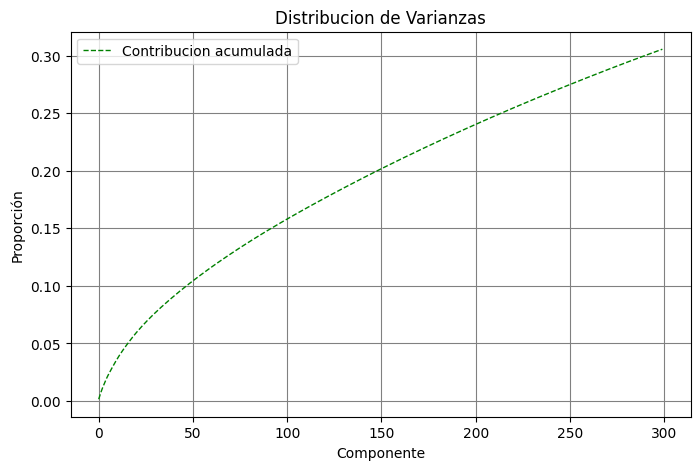

In [45]:
svd_vr=svd.explained_variance_ratio_
wi.distribucion_vr(svd_vr)

In [46]:
q=300  #debe ser <= 300 o debes correr de nuevo el algoritmo más arriba
lsa_rep=wi.get_representativos(dlsa,q)
print(lsa_rep.shape)
lsa_rep.head()

(2117, 301)


,doc_id,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
0,1886236,0.144606,-0.035454,-0.027174,-0.065392,-0.050102,0.021952,0.025118,-0.015155,-0.034800,...,-0.013656,0.003250,-0.004791,0.004599,0.007188,0.015899,0.009976,-0.011148,0.013769,-0.018902
1,1878783,0.196944,-0.070551,0.023415,-0.087179,-0.036223,-0.043035,-0.032487,-0.016263,0.020750,...,-0.021022,-0.005959,0.036866,-0.001384,0.000327,-0.010311,-0.027345,0.003721,0.019572,0.007920
2,1882951,0.135209,-0.019949,-0.033558,0.045555,0.009666,0.004139,-0.021153,-0.009239,-0.020196,...,0.057586,-0.034646,-0.010839,0.003405,0.001095,0.014104,-0.017087,-0.002599,-0.031880,0.004770
3,1888749,0.148258,-0.016088,-0.044650,0.059701,0.005284,0.005766,-0.021263,-0.018914,-0.047110,...,-0.025677,-0.045258,0.000743,0.003936,-0.005705,0.007806,0.012971,-0.023004,0.037212,0.037271
4,1880333,0.170300,-0.014052,-0.078178,0.082517,0.066849,-0.036881,0.044592,-0.020503,0.012222,...,-0.026260,0.015500,-0.063230,0.040825,-0.007310,-0.004958,0.018011,0.022304,-0.017743,0.022114


In [47]:
edf_lsa=wi.modela_documentos_rep(lsa_rep)
print(edf_lsa.shape)
edf_lsa.head()

(2117, 2)


,doc_id,Vectores
0,1886236,"[0.14460559304228576, -0.03545442672860715, -0..."
1,1878783,"[0.19694370369382522, -0.07055061062639882, 0...."
2,1882951,"[0.13520895423487816, -0.01994867984032684, -0..."
3,1888749,"[0.1482577101780329, -0.016088363657322233, -0..."
4,1880333,"[0.17029982503162464, -0.014052109317783432, -..."


In [53]:
docus

,doc_id,Texto,clase
0,1879679,marion jones farquhar noviembre marzo primera ...,0
1,1872685,george matthias von martens botánico alemán ma...,0
2,1896519,puente libertad ponte della libertà italiano p...,0
3,1874136,guillemont población comuna francesa región pi...,0
4,1876977,dimensión latina internacional octavo álbum ag...,0


In [58]:
'1876977'	in edf_lsa["doc_id"].to_list()

True

In [63]:
docus=docus[docus['doc_id'].isin(edf_lsa["doc_id"].to_list())]
docus

,doc_id,Texto,clase
2,1896519,puente libertad ponte della libertà italiano p...,0
4,1876977,dimensión latina internacional octavo álbum ag...,0


In [64]:
k=1
vecinos_lsa=wi.k_vecinos_mas_cercanos(docus,edf_lsa,k)

In [66]:
print(vecinos_lsa['1896519'])

[['1887079', 0.20880958140434677]]


In [68]:
test1=df[df['doc_id']=='1896519'].Texto.values[0][:400]
test2=df[df['doc_id']=='1876977'].Texto.values[0][:400]
print(test1)
print(test2)

puente libertad ponte della libertà italiano puente carretero une ciudad venecia piazzale roma continente diseñado ingeniero eugenio miozzi inaugurado benito mussolini abril bajo nombre puente littorio única vía acceso circulación vehículos capital región véneto puente construido casi toda longitud junto antiguo puente ferroviario construido reino lombardovéneto final segunda guerra mundial rebaut
dimensión latina internacional octavo álbum agrupación venezolana dimensión latina editado disquera top hits formato larga duración vinilo rpm primer disco agrupación cantante bajista original oscar dleón separó iniciar carrera solista dleón sustituido argenis carruyo voces gustavo carmona bajo mientras producción recayó manos césar monge canciones lado mires así canta wladimir reir cantar canta a


In [70]:
print(vecinos_lsa['1876977'])

[['1876944', 0.3030352710865919]]


**Referencias** <br>

Yoshua Bengio, Réjean Ducharme, Pascal Vincent, and Christian Janvin. 2003. A neural probabilistic language model. J. Mach. Learn. Res. 3 (March 2003), 1137-1155.

Tomas Mikolov, Ilya Sutskever, Kai Chen, Greg Corrado, and Jeffrey Dean. 2013. Distributed representations of words and phrases and their compositionality. In _Proceedings of the 26th International Conference on Neural Information Processing Systems - Volume 2 (NIPS'13)_, C. J. C. Burges, L. Bottou, M. Welling, Z. Ghahramani, and K. Q. Weinberger (Eds.), Vol. 2. Curran Associates Inc., USA, 3111-3119.

Xin Rong. 2014. Word2vec Parameter Learning Explained.arXiv 1411.2738. disponible en linea {http://arxiv.org/abs/1411.2738}